## 数据预处理

>在21号风机的数据集中，有正常时间区间的数据、故障时间区间的数据以及无效数据，且其中正常时间区间覆盖的数据远远大于故障时间区间覆盖的数据。因此需要对无效数据进行过滤删除，以及为了防止决策树偏向于主导类，需要进行类平衡，即对正常时间区间覆盖的数据样本进行欠采样。

首先，给每个样本增添一个特征`isfailureinfo`。对故障时间区间覆盖的数据行标记为1，正常时间区间覆盖的数据行标记为0，无效数据不做标记。

In [23]:
import pandas as pd
import numpy as np
import sys
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

data         = pd.read_csv("../datasets/DraughtFan/train/21/21_data.csv")
failure_time = pd.read_csv("../datasets/DraughtFan/train/21/21_failureInfo.csv")
normal_time  = pd.read_csv("../datasets/DraughtFan/train/21/21_normalInfo.csv")
fail,normal = pd.DataFrame(),pd.DataFrame()

for start, end in zip(failure_time['startTime'],failure_time['endTime']):
    fail = pd.concat([fail,
                    data[(((start <= data['time']) & (data['time'] <= end)))]])
fail['isfailureinfo'] = 1

for start, end in zip(normal_time['startTime'], normal_time['endTime']):
    normal = pd.concat([normal,
                        data[(((start <= data['time']) & (data['time'] <= end)))]])
normal['isfailureinfo'] = 0

data = pd.concat([fail,normal])
data

,time,wind_speed,generator_speed,power,wind_direction,wind_direction_mean,yaw_position,yaw_speed,pitch1_angle,pitch2_angle,...,environment_tmp,int_tmp,pitch1_ng5_tmp,pitch2_ng5_tmp,pitch3_ng5_tmp,pitch1_ng5_DC,pitch2_ng5_DC,pitch3_ng5_DC,group,isfailureinfo
12290,2015-11-04 22:15:38,1.236727,1.270128,0.741577,-0.436153,-0.995803,0.176962,0.100571,0.191111,0.275556,...,-0.088306,0.129650,1.323077,1.246154,0.615385,2.28,-0.04,0.60,118,1
12291,2015-11-04 22:15:45,1.657155,1.270128,0.942854,-0.401626,0.458182,0.165313,-0.213382,0.191111,0.275556,...,-0.088306,0.129650,1.323077,1.246154,0.615385,0.56,-0.36,0.36,118,1
12292,2015-11-04 22:15:52,1.539140,1.230242,0.784649,-0.251433,0.544307,0.176962,0.100571,0.191111,0.275556,...,-0.088306,0.129650,1.323077,1.260000,0.615385,-1.32,-0.72,0.28,118,1
12293,2015-11-04 22:15:59,1.406373,1.263480,0.892798,-0.436153,-0.857750,0.165313,-0.213382,0.191111,0.275556,...,-0.088306,0.129650,1.323077,1.276923,0.615385,0.56,2.44,2.52,118,1
12294,2015-11-04 22:16:06,1.760418,1.270128,0.990918,-0.311856,0.743153,0.165313,-0.213382,0.191111,0.275556,...,-0.088306,0.129650,1.323077,1.276923,0.615385,2.84,1.84,-0.68,118,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190489,2015-12-01 18:58:43,1.395310,1.286747,1.640705,1.721793,1.765249,0.479635,0.135455,0.191111,0.240000,...,0.811189,0.818041,0.769231,0.875385,1.353846,1.12,-0.96,0.96,1854,0
190490,2015-12-01 18:58:50,1.258855,1.273452,1.666740,1.680360,1.007859,0.473811,-0.038964,0.191111,0.240000,...,0.825391,0.818041,0.783077,0.875385,1.353846,1.16,-0.80,0.96,1854,0
190491,2015-12-01 18:58:57,1.314174,1.250185,1.438443,1.830553,1.470146,0.473811,-0.038964,0.191111,0.240000,...,1.314591,0.818041,0.798462,0.875385,1.353846,0.88,-0.96,1.20,1854,0
190492,2015-12-01 18:59:04,1.258855,1.316661,2.161345,1.623390,0.180810,0.473811,-0.038964,0.191111,0.240000,...,1.314591,0.818041,0.815385,0.860000,1.353846,1.00,-0.88,1.28,1854,0


In [24]:
data.to_csv('../datasets/DraughtFan/train/21/temp.csv')
# data

## 特征加工与选择

21号风机数据集中约有19万数据样本，故障时间区间覆盖的样本约占 1/19 ，对样本训练集采用`欠采样`的方式进行划分，这里使用 **故障区间数据训练样本:正常区间数据训练样本 = 5:1**，采取其中50000条正常数据和10000条故障数据作为训练样本。

此外，太多特征容易导致决策树过拟合，对于一些相似的特征可以进行归一处理，比如 三个叶片的叶片角度、速度、变桨电机温度较为一致，此时仅选第一个叶片作为训练特征，即：pitch1_angle,pitch1_speed, pitch1_moto_tmp

In [25]:
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz

data = pd.read_csv("../datasets/DraughtFan/train/21/temp.csv")
# print(data.shape[0])
data = data[((data['isfailureinfo']==1) | (data['isfailureinfo']==0))]  #删掉无效数据

fail   = data[(data['isfailureinfo']==1)]    # 故障数据
normal = data[(data['isfailureinfo']==0)]    # 正常数据

# 欠采样, 随机选取 正常:故障 = 5:1 数据为训练集
normal  = normal.sample(n=50000)
fail = fail.sample(n=10000)

# 合并数据集
data = pd.concat([normal,fail],ignore_index=True)

# 选取主要特征集
target = data['isfailureinfo']
data = data[['wind_speed','generator_speed','power','wind_direction_mean',
               'pitch1_angle','pitch1_speed','pitch1_moto_tmp',
               'acc_x','acc_y','environment_tmp','int_tmp','pitch1_ng5_tmp',
               'pitch1_ng5_DC']]

# 训练集、测试集划分
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=0.2,random_state=1)

feature = ['wind_speed','generator','power','wind_direction_mean',
            'pitch1_angle','pitch1_speed','pitch1_moto_tmp',
            'acc_x','acc_y','environment_tmp','int_tmp','pitch1_ng5_tmp',
            'pitch1_ng5_DC']


## 算法模型生成

ID3决策树基于 **信息熵** 作为划分属性标准，具有较好的泛化能力, 基于风机叶片数据，对决策树进行了以下调整：

1. 为防止树深度过大，设置了`max_depth = 5`
2. 针对于训练样本集 **正常类:故障类 = 5:1**，设置了每个类的样本权重`class_weight={0:1, 1:5})`,防止决策树偏向于正常类
3. 当叶子节点上样本数量较少时，容易导致过拟合，针对此问题，设置了叶节点中最少采样数 `min_samples_leaf = 20`

模型精确度： 91.58333333333334 %



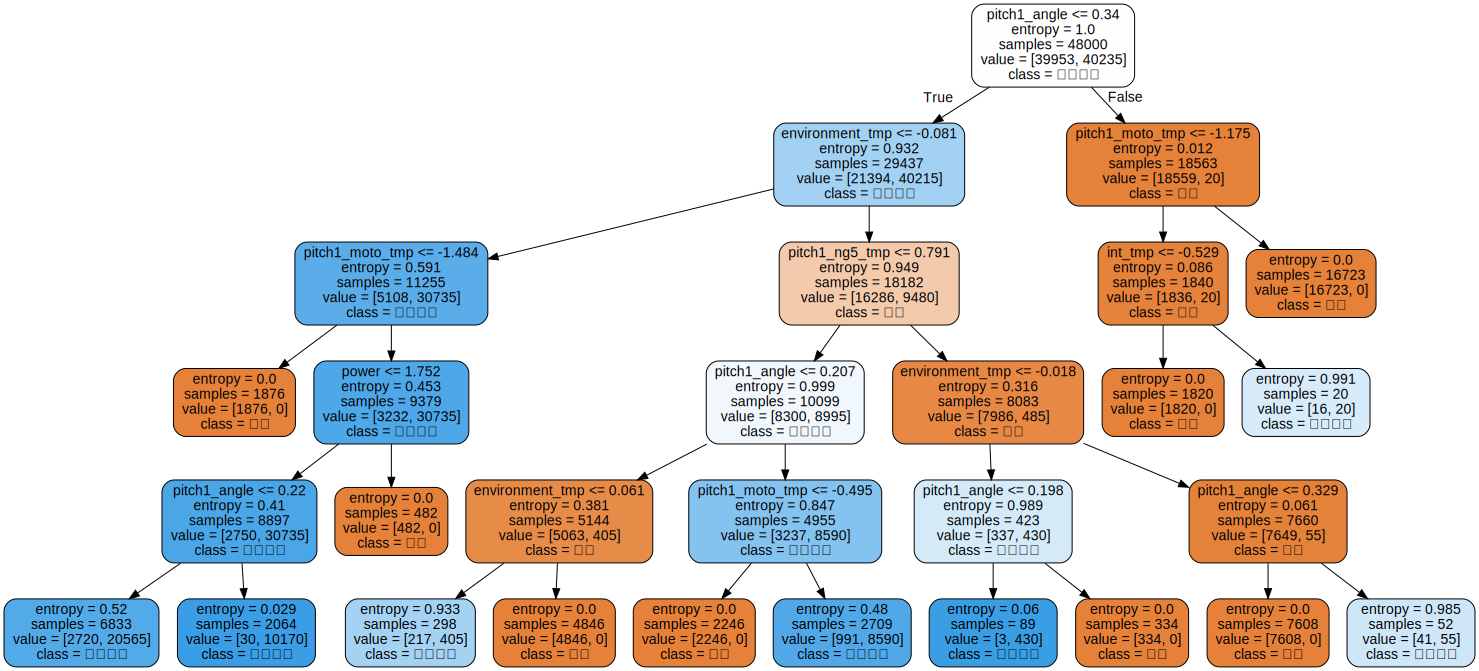

In [28]:
# ID3决策树算法生成, 最大深度设为5
clf = tree.DecisionTreeClassifier(criterion='entropy',
                                  max_depth=5,
                                  class_weight={0:1, 1:5},
                                  min_samples_leaf=20)
clf.fit(X_train,y_train)

# 分析模型所得精度
score = clf.score(X_test, y_test)
print("模型精确度：",score*100,"%\n")

# graphviz决策树图生成
source = tree.export_graphviz(clf,
                              feature_names=feature,
                              out_file=None,
                              class_names=['正常','结冰故障'],
                              filled=True,
                              rounded=True)
graph = graphviz.Source(source)
graph  

CART决策树算法同上处理

模型精确度： 92.5 %



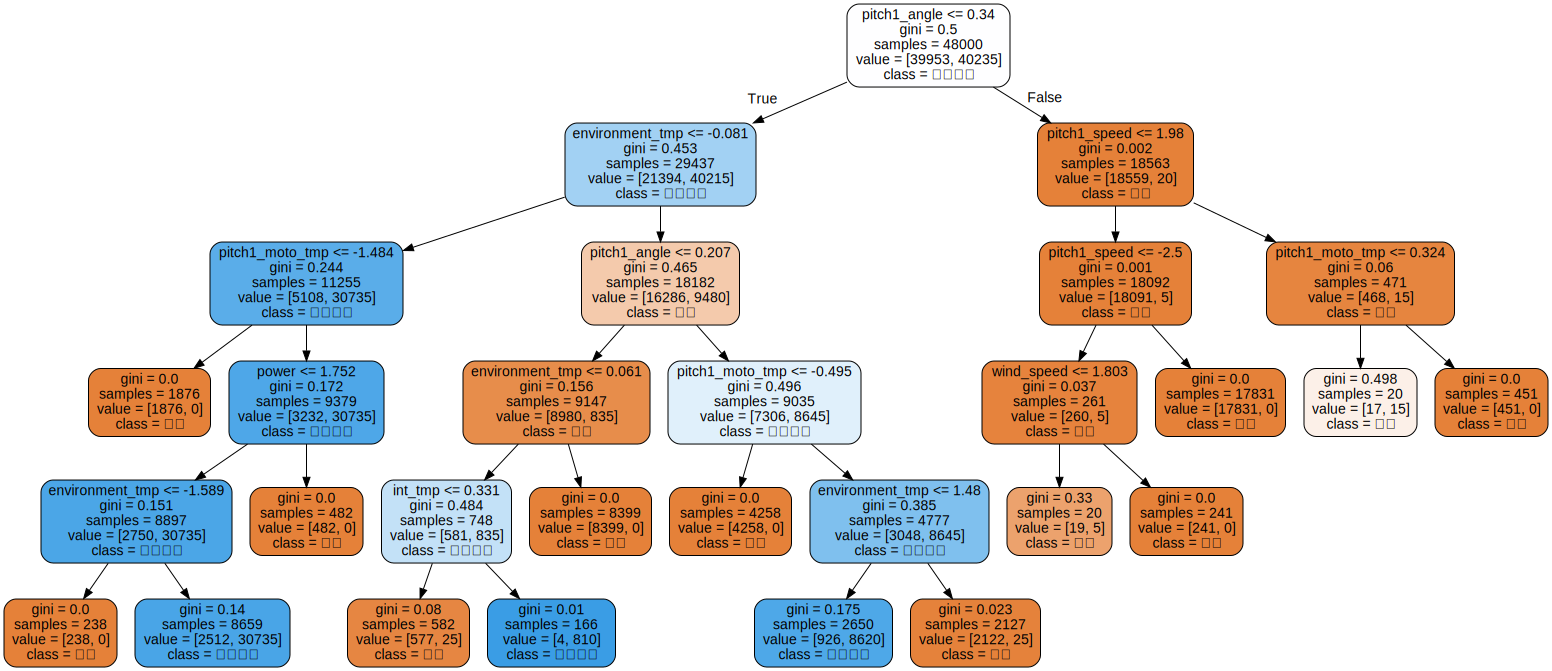

In [27]:
# CART决策树算法生成, 最大深度设为5
clf = tree.DecisionTreeClassifier(criterion='gini',
                                  max_depth=5,             # 设置树的最大深度，防止
                                  class_weight={0:1,1:5},
                                  min_samples_leaf=20)  # 设置权重，01类训练样本比为5:1
clf.fit(X_train,y_train)

# 分析模型所得精度
score = clf.score(X_test, y_test)
print("模型精确度：",score*100,"%\n")

# graphviz决策树图生成
source = tree.export_graphviz(clf,
                              feature_names=feature,
                              out_file=None,
                              class_names=['正常','结冰故障'],
                              filled=True,
                              rounded=True)
graph = graphviz.Source(source)
graph  

In [ ]:
# C4D决策树算法